<a href="https://colab.research.google.com/github/ale-camer/Data-Science/blob/Finance/Switzerland_Jobless_Rate_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import requests # packages
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [28]:
data = requests.get("https://data.snb.ch/api/cube/amarbma/data/csv/en").text # data
data[:100]

'"CubeId";"amarbma"\r\n"PublishingDate";"2022-04-21 09:00"\r\n\r\n"Date";"D0";"Value"\r\n"1948-01";"K";\r\n"194'

In [8]:
# PREPROCESSING

data = str(data).splitlines() # convert each line an element of a list
data = pd.Series(data).str.split(';', expand=True) # separate each element by semicolon
data = data.iloc[5:,:].rename(columns = {0:'date',1:'category_code',2:'value'}) # delete unnecesary data and rename columns
for col in data.columns: # clean data
    data[col] = data[col].str.replace('"','').replace('', 0)
data['value'] = pd.to_numeric(data['value']) # format data
data = data[data['category_code'] == 'T1'] # keep only total jobless rate data
data.drop('category_code',axis=1,inplace=True) # drop category column
data.set_index('date',inplace=True) # set date as index
data.index = pd.to_datetime(data.index)
data.head()

,value
date,
1948-01-01,0.219472
1948-02-01,0.282811
1948-03-01,0.050011
1948-04-01,0.043687
1948-05-01,0.040072


In [9]:
date = '2015-12-01'
train, test = data[data.index <= date], data[data.index > date] # train and test sets
window_size, cycle = 10, 12
x_train, x_test, y_train, y_test = pd.concat([train['value'].shift(w, fill_value=0) for w in range(1, window_size+1)], axis=1, keys=[f"value_{w}" for w in range(1, window_size+1)]), \
    pd.concat([test['value'].shift(w, fill_value=0) for w in range(1, window_size+1)], axis=1, keys=[f"value_{w}" for w in range(1, window_size+1)]), \
    train['value'], test['value']
x_train, x_test = x_train.values.reshape((x_train.shape[0], 1, window_size)), x_test.values.reshape((x_test.shape[0], 1, window_size))
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((816, 1, 10), (75, 1, 10), (816,), (75,))

In [12]:
model = tf.keras.models.Sequential([ # model
  tf.keras.layers.InputLayer(input_shape=[1, window_size]),
  tf.keras.layers.LSTM(cycle),
  tf.keras.layers.Dense(1),
])
model.compile(loss="mean_squared_error", optimizer="adam", metrics="mean_squared_error")
history = model.fit(x_train, y_train, epochs=100, batch_size=1, verbose=True)
preds = model.predict(x_test) # prediction
rsme, corr = np.sqrt(np.mean((preds.flatten() - y_test)**2)), np.corrcoef(preds.flatten(), y_test)[0][1] # evaluation

Epoch 1/100
816/816 [==============================] - 4s 3ms/step - loss: 0.6690 - mean_squared_error: 0.6690
Epoch 2/100
816/816 [==============================] - 2s 3ms/step - loss: 0.0657 - mean_squared_error: 0.0657
Epoch 3/100
816/816 [==============================] - 2s 3ms/step - loss: 0.0461 - mean_squared_error: 0.0461
Epoch 4/100
816/816 [==============================] - 2s 3ms/step - loss: 0.0393 - mean_squared_error: 0.0393
Epoch 5/100
816/816 [==============================] - 3s 3ms/step - loss: 0.0308 - mean_squared_error: 0.0308
Epoch 6/100
816/816 [==============================] - 3s 4ms/step - loss: 0.0284 - mean_squared_error: 0.0284
Epoch 7/100
816/816 [==============================] - 2s 3ms/step - loss: 0.0269 - mean_squared_error: 0.0269
Epoch 8/100
816/816 [==============================] - 2s 3ms/step - loss: 0.0236 - mean_squared_error: 0.0236
Epoch 9/100
816/816 [==============================] - 2s 2ms/step - loss: 0.0227 - mean_squared_error: 0.0227
E

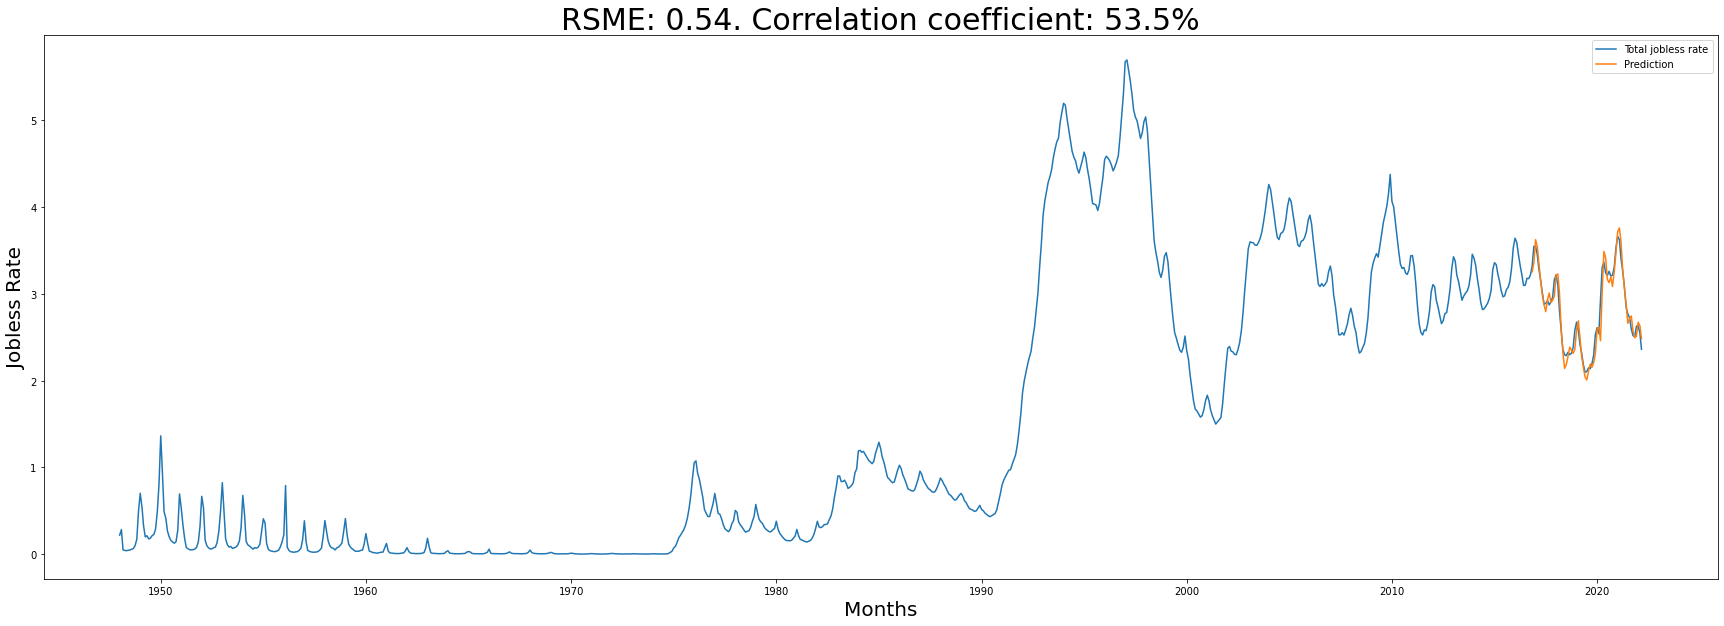

In [26]:
plt.figure(figsize=(30,10)) # plot
plt.plot(data.index, data['value'], label="Total jobless rate")
plt.plot(test.index[window_size:], preds[window_size:], label="Prediction")
plt.xlabel("Months",fontsize=20)
plt.ylabel("Jobless Rate",fontsize=20)
# plt.text(x=0.5,y=0.5,s=f"RSME: {round(rsme,2)}. Correlation coefficient: {round(corr*100,2)}%",fontsize=20)
plt.title(f"RSME: {round(rsme,2)}. Correlation coefficient: {round(corr*100,2)}%",fontsize=30)
plt.legend()
plt.show()